# Drawdown Prediction Models for NIFTY 50 

Creating different models - random forest, logistic regression, XGBoost to predict monthly drawdowns in NIFTY 50. I explore the correlation for different features like momentum, consumption, USD/INR, and CAPE along with different hyperparameters.

In [ ]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


# Turn off warnings
warnings.filterwarnings("ignore")

### Get NIFTY 50 historical data

In [ ]:
# Define ticker and date rangticker = "BSE-500.BO"
start_date = "1980-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

ticker = '^NSEI'
# Download data
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
data = data[['Close']]
yf_market_data = data['Close'].resample('ME').last()
yf_market_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,^NSEI
Date,
2007-09-17,4494.649902
2007-09-18,4546.200195
2007-09-19,4732.350098
2007-09-20,4747.549805
2007-09-21,4837.549805
...,...
2025-09-17,25330.250000
2025-09-18,25423.599609


In [4]:
nifty_historical = pd.read_csv("./data/NIFTY 50_Historical_PRICE.csv")
nifty_historical['Date'] = pd.to_datetime(nifty_historical['Date'])
nifty_historical = nifty_historical.set_index('Date').resample('ME').ffill()
nifty_historical = nifty_historical[:'2007-10-01']
nifty_historical  = pd.DataFrame(nifty_historical['Close'])
nifty_historical = nifty_historical.rename(columns = {'Close': '^NSEI'})

In [5]:
market_data = pd.concat([nifty_historical, yf_market_data], axis=0)
market_data.iloc[5:]

,^NSEI
Date,
1990-12-31,330.860000
1991-01-31,314.360000
1991-02-28,379.940000
1991-03-31,366.450000
1991-04-30,389.010000
...,...
2025-05-31,24750.699219
2025-06-30,25517.050781
2025-07-31,24768.349609


In [6]:
initial_value = 100

market_data['Return'] = market_data['^NSEI'].pct_change()
market_data['Portfolio'] = initial_value * (1 + market_data['Return']).cumprod()
market_data['Portfolio'].iloc[0] = initial_value

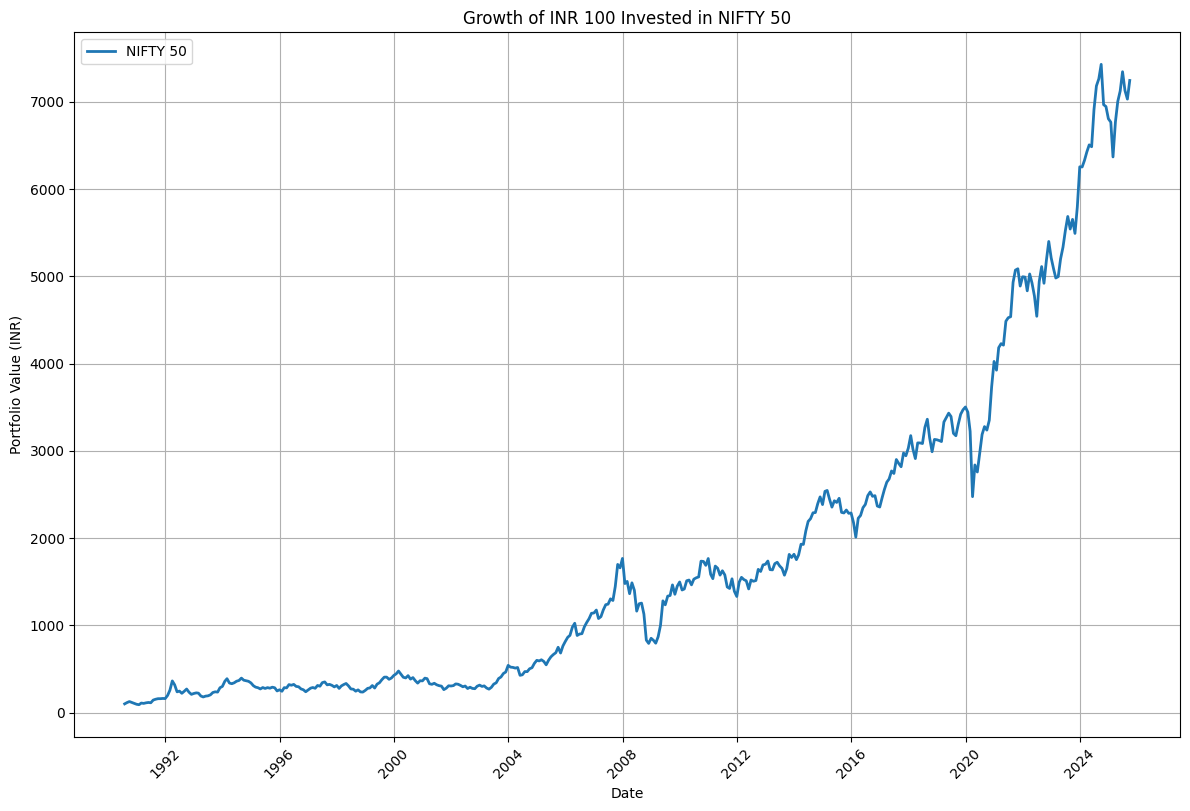

In [7]:
# Assuming 'portfolios' dictionary has the portfolios for each factor with 'Date' and 'Portfolio_Value'

# Step 1: Plotting the growth of portfolios for each factor
plt.figure(figsize=(12, 8))

# Plot the portfolio value over time
plt.plot(market_data.index, market_data['Portfolio'], label='NIFTY 50', linewidth = 2)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.title('Growth of INR 100 Invested in NIFTY 50')
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [8]:
market_data

,^NSEI,Return,Portfolio
Date,,,
1990-07-31,347.440000,NaN,100.000000
1990-08-31,400.060000,0.151451,115.145061
1990-09-30,439.720000,0.099135,126.559982
1990-10-31,403.660000,-0.082007,116.181211
1990-11-30,367.690000,-0.089110,105.828344
...,...,...,...
2025-05-31,24750.699219,0.017116,7123.733369
2025-06-30,25517.050781,0.030963,7344.304277
2025-07-31,24768.349609,-0.029341,7128.813496


### Return distribution

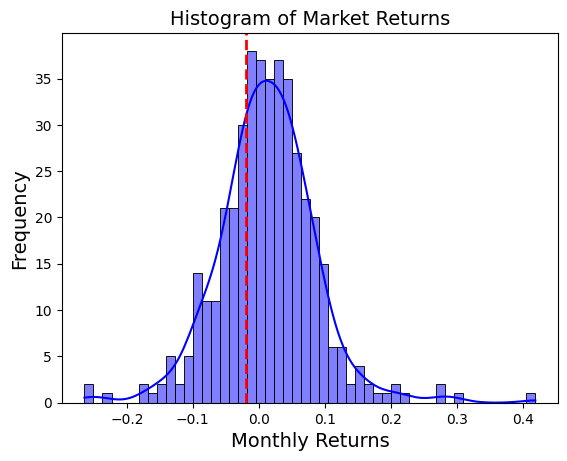

In [10]:
# Sample Data (Replace with your actual market_data DataFrame)
# market_data['Return'] should already contain daily returns
sns.histplot(market_data['Return'], bins=50, kde=True, color="blue")
plt.axvline(x=-0.02, color='red', linestyle='--', linewidth=2, label="Threshold (-0.02)")

# Set title and labels
plt.title("Histogram of Market Returns", fontsize=14)
plt.xlabel("Monthly Returns", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show plot
plt.show()


### Creating Price Momentum Features and "Next Month Return" as label column

In [83]:
market_data['next_month_return'] = market_data['Return'].shift(-1)

In [84]:
windows = [1, 3, 6, 9, 12]

market_data['momentum_1_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(1)
market_data['momentum_3_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(3)
market_data['momentum_6_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(6)
market_data['momentum_9_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(9)
market_data['momentum_12_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(12)


market_data.head(13)

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime
Date,,,,,,,,,,,
1992-07-31,767.94,-0.102706,221.028091,0.107977,NaN,NaN,NaN,NaN,NaN,1,1
1992-08-31,850.86,0.107977,244.894082,0.102579,1.107977,NaN,NaN,NaN,NaN,1,1
1992-09-30,938.14,0.102579,270.014967,-0.136728,1.102579,NaN,NaN,NaN,NaN,0,0
1992-10-31,809.87,-0.136728,233.096362,-0.103091,0.863272,1.054601,NaN,NaN,NaN,0,0
1992-11-30,726.38,-0.103091,209.066314,0.048088,0.896909,0.853701,NaN,NaN,NaN,1,1
1992-12-31,761.31,0.048088,219.119848,0.031485,1.048088,0.811510,NaN,NaN,NaN,1,1
1993-01-31,785.28,0.031485,226.018881,-0.014135,1.031485,0.969637,1.022580,NaN,NaN,1,1
1993-02-28,774.18,-0.014135,222.824085,-0.146826,0.985865,1.065806,0.909879,NaN,NaN,0,0
1993-03-31,660.51,-0.146826,190.107644,-0.057668,0.853174,0.867597,0.704063,NaN,NaN,0,0


In [85]:
market_data.dropna(inplace=True)

### Training on 80% Data using Momentum Features

In [86]:
# Create the 'positive_returns' column
market_data['positive_returns'] = (market_data['next_month_return'] > -0.02).astype(int)

split_of_date_to_use = round(0.8*len(market_data))
# Features and target variable
X = market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']].iloc[:split_of_date_to_use]
y = market_data['positive_returns'].iloc[:split_of_date_to_use]

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X, y)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.58064516 0.58064516 0.51612903 0.62903226 0.60655738]
Mean Accuracy: 0.5826
Standard Deviation: 0.0378


### Making Predictions and Evaluate Performance on Training Data

In [87]:
market_data['market_regime'] = clf.predict(market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']])

In [88]:
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(market_data["positive_returns"], market_data["market_regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)


          Predicted 0  Predicted 1
Actual 0           95           16
Actual 1           15          260


### Making Predictions on Test Data

In [89]:
test_data = market_data.iloc[split_of_date_to_use:]
test_data['market_regime'] = clf.predict(test_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']])

In [90]:
# Compute Confusion Matrix
cm = confusion_matrix(test_data["positive_returns"], test_data["market_regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)

          Predicted 0  Predicted 1
Actual 0            6           14
Actual 1           11           46


In [91]:
test_data.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime
Date,,,,,,,,,,,
2019-03-31,11570.000000,0.072041,3330.071379,0.015398,1.072041,1.065127,1.058511,1.079865,1.143993,1,1
2019-04-30,11748.150391,0.015398,3381.346532,0.014866,1.015398,1.084683,1.131087,1.034487,1.093935,1,1
2019-05-31,11922.799805,0.014866,3431.614035,-0.011235,1.014866,1.104730,1.096173,1.020744,1.110528,1,1
2019-06-30,11788.849609,-0.011235,3393.060560,-0.056905,0.988765,1.018915,1.085275,1.078533,1.100291,0,1
2019-07-31,11118.000000,-0.056905,3199.976974,-0.008522,0.943095,0.946362,1.026503,1.070418,0.978999,1,1


### Training on Full Data

In [92]:
X_final = market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']].iloc[:-1]
y_final = market_data['positive_returns'].iloc[:-1]

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X_final, y_final, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X_final, y_final)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.55844156 0.62337662 0.61038961 0.67532468 0.68831169]
Mean Accuracy: 0.6312
Standard Deviation: 0.0469


### Next Month Prediction (as of today)
Output of 1 will mean no drawdown. Output of 0 will mean drawdown predicted. This is based on just momentum features

In [93]:
last_month = np.array(market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']].iloc[-1]).reshape(1,-1)

final_prediction = clf.predict(last_month)
final_prediction[0]

np.int64(0)

## Adding and Testing new Features

### 1. Consumption EPS
Consumption can be a leading indicator of returns as India is a consumption driven economy. We use the EPSof an index of consumer companies as a proxy for consumption since this data is more readily available and updates everyday.

In [94]:
nifty_consumption_pe = pd.read_csv("./data/NIFTY INDIA CONSUMPTION_Historical.csv")
nifty_consumption_pe['Date'] = pd.to_datetime(nifty_consumption_pe['Date'])
nifty_consumption_pe = nifty_consumption_pe.set_index('Date').resample('ME').last()
nifty_consumption_pe.replace("-", pd.NA, inplace=True)  # Convert '-' to NaN
nifty_consumption_pe.fillna(method="ffill", inplace=True)  # Forward fill
nifty_consumption_pe

,IndexName,P/E,P/B,Div Yield %
Date,,,,
2011-07-31,NIFTY INDIA CONSUMPTION,24.09,4.38,1.42
2011-08-31,NIFTY INDIA CONSUMPTION,22.78,3.80,1.62
2011-09-30,NIFTY INDIA CONSUMPTION,22.32,3.68,1.64
2011-10-31,NIFTY INDIA CONSUMPTION,23.53,3.91,1.55
2011-11-30,NIFTY INDIA CONSUMPTION,21.90,3.64,1.64
...,...,...,...,...
2024-10-31,NIFTY INDIA CONSUMPTION,47.06,9.00,0.94
2024-11-30,NIFTY INDIA CONSUMPTION,46.63,8.97,0.95
2024-12-31,NIFTY INDIA CONSUMPTION,46.77,9.02,0.94


In [95]:
ticker_consumption = '^CNXCONSUM'
# Download data
data_consumption = yf.download(ticker_consumption, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
data_consumption = data_consumption[['Close']]
data_consumption = data_consumption.resample('ME').last()

[*********************100%***********************]  1 of 1 completed


In [96]:
data_consumption['Close'].head()

Ticker,^CNXCONSUM
Date,
2025-04-30,11316.549805
2025-05-31,11383.150391
2025-06-30,11842.849609
2025-07-31,11739.099609
2025-08-31,12059.349609


In [97]:
nifty_consumption_pe['P/E'] = nifty_consumption_pe['P/E'].replace('-', '0').astype(float)
consumption_data_merged = pd.merge(data_consumption['Close'], nifty_consumption_pe, left_index= True, right_index=True)

In [98]:
consumption_data_merged['EPS'] = consumption_data_merged['^CNXCONSUM']/consumption_data_merged['P/E']
consumption_data_merged.loc[consumption_data_merged['EPS'] == np.float64('inf')]['EPS'] = 0

In [99]:
training_data_with_eps = pd.merge(market_data,consumption_data_merged['EPS'], left_index=True, right_index=True, how='left')
training_data_with_eps.tail()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS
Date,,,,,,,,,,,,
2025-03-31,23519.349609,0.063036,6769.326966,0.034646,1.063036,0.994694,0.911220,0.979540,1.053409,1,0,NaN
2025-04-30,24334.199219,0.034646,7003.856556,0.017116,1.034646,1.035128,1.005323,0.975274,1.076503,1,1,NaN
2025-05-31,24750.699219,0.017116,7123.733369,0.030963,1.017116,1.118691,1.025676,0.980773,1.098532,1,1,NaN
2025-06-30,25517.050781,0.030963,7344.304277,-0.029341,1.030963,1.084939,1.079182,0.988617,1.062741,0,1,NaN
2025-07-31,24768.349609,-0.029341,7128.813496,-0.013788,0.970659,1.017841,1.053596,1.023259,0.992674,1,1,NaN


### 2. Shiller's CAPE

In [100]:
sheet_id = "1ZcT4v4PzjwACcbzmwYXGwxLMRXtuQGwsSEPyONMcfcU"
sheet_name = "Sheet1"  # or your specific sheet name

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

cape = pd.read_csv(url)
cape['Date'] = pd.to_datetime(cape['Date'])
cape = cape.set_index('Date').resample('ME').last()
cape.tail()

,BSE Sensex CAPE 5,Sensex Close Price,P/E,EPS,Inflation Rate,Inflation Adjusted EPS,Inflation Adjusted Price,Last 120 Month EPS Inflation Adj
Date,,,,,,,,
2025-03-31,32.43,77414.92,21.58,3587.345690,0.0394,3451.362027,74480.39253,2296.541679
2025-04-30,33.33,80242.00,21.59,3716.628069,0.0340,3594.417861,77603.48162,2328.540286
2025-05-31,33.45,81451.00,22.68,3591.313933,0.0316,3481.304704,78955.99069,2360.428143
2025-06-30,33.93,83606.46,23.11,3617.761142,0.0293,3514.778143,81226.52288,2393.902282
2025-07-31,32.73,81081.72,23.62,3432.756986,0.0210,3362.151798,79414.02547,2426.133566


In [101]:
training_data_with_eps_and_cape = pd.merge(training_data_with_eps,cape['BSE Sensex CAPE 5'], left_index=True, right_index=True, how='left')
training_data_with_eps_and_cape.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS,BSE Sensex CAPE 5
Date,,,,,,,,,,,,,
1993-07-31,706.83,0.058921,203.439443,0.131319,1.058921,1.135616,0.900099,0.872770,0.920423,1,1,NaN,NaN
1993-08-31,799.65,0.131319,230.154847,0.034365,1.131319,1.218681,1.032899,1.100870,0.939814,1,1,NaN,NaN
1993-09-30,827.13,0.034365,238.064126,-0.012030,1.034365,1.239146,1.252260,1.086456,0.881670,1,1,NaN,NaN
1993-10-31,817.18,-0.012030,235.200322,0.210113,0.987970,1.156120,1.312908,1.040622,1.009026,1,1,NaN,NaN
1993-11-30,988.88,0.210113,284.618927,0.054223,1.210113,1.236641,1.507071,1.277326,1.361381,1,1,NaN,NaN


In [102]:
windows = [1, 3, 6, 9, 12]

for window in windows:
    column_name = 'momentum_' + str(window) + '_CAPE'
    training_data_with_eps_and_cape[column_name] = training_data_with_eps_and_cape['BSE Sensex CAPE 5'] / training_data_with_eps_and_cape['BSE Sensex CAPE 5'].shift(window)

training_data_with_eps_and_cape.tail()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS,BSE Sensex CAPE 5,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE
Date,,,,,,,,,,,,,,,,,,
2025-03-31,23519.349609,0.063036,6769.326966,0.034646,1.063036,0.994694,0.911220,0.979540,1.053409,1,0,NaN,32.43,1.042095,1.017252,0.945481,0.979462,0.983025
2025-04-30,24334.199219,0.034646,7003.856556,0.017116,1.034646,1.035128,1.005323,0.975274,1.076503,1,1,NaN,33.33,1.027752,1.102183,1.017710,0.980583,1.011533
2025-05-31,24750.699219,0.017116,7123.733369,0.030963,1.017116,1.118691,1.025676,0.980773,1.098532,1,1,NaN,33.45,1.003600,1.074871,1.059215,0.993466,1.027966
2025-06-30,25517.050781,0.030963,7344.304277,-0.029341,1.030963,1.084939,1.079182,0.988617,1.062741,0,1,NaN,33.93,1.014350,1.046253,1.064304,0.989213,1.024766
2025-07-31,24768.349609,-0.029341,7128.813496,-0.013788,0.970659,1.017841,1.053596,1.023259,0.992674,1,1,NaN,32.73,0.964633,0.981998,1.082341,0.999389,0.962930


### 3. USD/INR

In [103]:
fred_data = pd.read_csv("./data/USD_INR.csv")
fred_data['Date'] = pd.to_datetime(fred_data['Date'], format='%d-%m-%Y')
fred_data = fred_data.set_index('Date').resample('ME').last()
fred_data = fred_data.rename(columns = {'USD/INR': 'USDINR=X'})


ticker = 'USDINR=X'
# Download data
start_date = fred_data.index[-1] + MonthEnd(1)
usd_inr = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
usd_inr = usd_inr[['Close']]
usd_inr = usd_inr.resample('ME').last()

usd_inr = pd.concat([fred_data,usd_inr['Close']], axis=0)
usd_inr.head()

[*********************100%***********************]  1 of 1 completed


,USDINR=X
Date,
1973-01-31,8.00
1973-02-28,7.52
1973-03-31,7.55
1973-04-30,7.53
1973-05-31,7.39


In [104]:
training_data_with_eps_and_cape_and_usdinr = pd.merge(training_data_with_eps_and_cape, usd_inr['USDINR=X'], left_index=True, right_index=True, how='left')
training_data_with_eps_and_cape_and_usdinr.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS,BSE Sensex CAPE 5,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,USDINR=X
Date,,,,,,,,,,,,,,,,,,,
1993-07-31,706.83,0.058921,203.439443,0.131319,1.058921,1.135616,0.900099,0.872770,0.920423,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.60
1993-08-31,799.65,0.131319,230.154847,0.034365,1.131319,1.218681,1.032899,1.100870,0.939814,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.63
1993-09-30,827.13,0.034365,238.064126,-0.012030,1.034365,1.239146,1.252260,1.086456,0.881670,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.53
1993-10-31,817.18,-0.012030,235.200322,0.210113,0.987970,1.156120,1.312908,1.040622,1.009026,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.43
1993-11-30,988.88,0.210113,284.618927,0.054223,1.210113,1.236641,1.507071,1.277326,1.361381,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.44


### Creating change / momentum features for the features

Intead of using the features as they are, we create "change" features which better represent recent directional movement of the features. This is a more efffective indicator than absolute value of the variables.

Creating momentum features for USD INR

In [105]:
windows = [1, 3, 6, 9, 12]

for window in windows:
    column_name = 'momentum_' + str(window) + '_USDINR'
    training_data_with_eps_and_cape_and_usdinr[column_name] = training_data_with_eps_and_cape_and_usdinr['USDINR=X'] / training_data_with_eps_and_cape_and_usdinr['USDINR=X'].shift(window)

training_data_with_eps_and_cape_and_usdinr.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,...,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,USDINR=X,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR
Date,,,,,,,,,,,,,,,,,,,,,
1993-07-31,706.83,0.058921,203.439443,0.131319,1.058921,1.135616,0.900099,0.872770,0.920423,1,...,NaN,NaN,NaN,NaN,31.60,NaN,NaN,NaN,NaN,NaN
1993-08-31,799.65,0.131319,230.154847,0.034365,1.131319,1.218681,1.032899,1.100870,0.939814,1,...,NaN,NaN,NaN,NaN,31.63,1.000949,NaN,NaN,NaN,NaN
1993-09-30,827.13,0.034365,238.064126,-0.012030,1.034365,1.239146,1.252260,1.086456,0.881670,1,...,NaN,NaN,NaN,NaN,31.53,0.996838,NaN,NaN,NaN,NaN
1993-10-31,817.18,-0.012030,235.200322,0.210113,0.987970,1.156120,1.312908,1.040622,1.009026,1,...,NaN,NaN,NaN,NaN,31.43,0.996828,0.994620,NaN,NaN,NaN
1993-11-30,988.88,0.210113,284.618927,0.054223,1.210113,1.236641,1.507071,1.277326,1.361381,1,...,NaN,NaN,NaN,NaN,31.44,1.000318,0.993993,NaN,NaN,NaN


Momentum features for consumtion EPS

In [106]:
windows = [1, 3, 6, 9, 12]

for window in windows:
    column_name = 'momentum_' + str(window) + 'consumption_eps'
    training_data_with_eps_and_cape_and_usdinr[column_name] = training_data_with_eps_and_cape_and_usdinr['EPS'] / training_data_with_eps_and_cape_and_usdinr['EPS'].shift(window)

training_data_with_eps_and_cape_and_usdinr['2003-12-31':]

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,...,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1consumption_eps,momentum_3consumption_eps,momentum_6consumption_eps,momentum_9consumption_eps,momentum_12consumption_eps
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-31,1879.750000,0.163752,541.028667,-0.037239,1.163752,1.326477,1.657409,1.921642,1.719021,0,...,0.994107,0.994976,0.981681,0.958342,0.948958,NaN,NaN,NaN,NaN,NaN
2004-01-31,1809.750000,-0.037239,520.881303,-0.005222,0.962761,1.163153,1.526121,1.937530,1.737054,1,...,0.994951,0.999779,0.982015,0.956724,0.947522,NaN,NaN,NaN,NaN,NaN
2004-02-29,1800.300000,-0.005222,518.161409,-0.015775,0.994778,1.114564,1.327117,1.788141,1.692966,1,...,1.000000,0.989088,0.987794,0.962821,0.950902,NaN,NaN,NaN,NaN,NaN
2004-03-31,1771.900000,-0.015775,509.987336,0.013658,0.984225,0.942625,1.250370,1.562315,1.811388,1,...,0.957635,0.952799,0.948012,0.935345,0.913108,NaN,NaN,NaN,NaN,NaN
2004-04-30,1796.100000,0.013658,516.952567,-0.173988,1.013658,0.992458,1.154380,1.514610,1.922916,0,...,1.025806,0.982348,0.982131,0.964680,0.939835,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,23519.349609,0.063036,6769.326966,0.034646,1.063036,0.994694,0.911220,0.979540,1.053409,1,...,0.977586,0.999869,1.021237,1.026507,1.026384,NaN,NaN,NaN,NaN,NaN
2025-04-30,24334.199219,0.034646,7003.856556,0.017116,1.034646,1.035128,1.005323,0.975274,1.076503,1,...,0.995698,0.984178,1.013214,1.017208,1.020743,NaN,NaN,NaN,NaN,NaN
2025-05-31,24750.699219,0.017116,7123.733369,0.030963,1.017116,1.118691,1.025676,0.980773,1.098532,1,...,1.002237,0.975558,1.010432,1.018267,1.023149,NaN,NaN,NaN,NaN,NaN


In [107]:
training_data_final = training_data_with_eps_and_cape_and_usdinr[['momentum_1_1',
       'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1',
       'BSE Sensex CAPE 5',
       'momentum_1_USDINR', 'momentum_3_USDINR', 'momentum_6_USDINR', 'momentum_9_USDINR', 'momentum_12_USDINR', 
       'momentum_1_CAPE','momentum_3_CAPE','momentum_6_CAPE','momentum_9_CAPE','momentum_12_CAPE', 
       'positive_returns', 'next_month_return']]

training_data_final.head()

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,positive_returns,next_month_return
Date,,,,,,,,,,,,,,,,,,
1993-07-31,1.058921,1.135616,0.900099,0.872770,0.920423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.131319
1993-08-31,1.131319,1.218681,1.032899,1.100870,0.939814,NaN,1.000949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.034365
1993-09-30,1.034365,1.239146,1.252260,1.086456,0.881670,NaN,0.996838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,-0.012030
1993-10-31,0.987970,1.156120,1.312908,1.040622,1.009026,NaN,0.996828,0.994620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.210113
1993-11-30,1.210113,1.236641,1.507071,1.277326,1.361381,NaN,1.000318,0.993993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.054223


In [108]:
training_data_final = training_data_final.dropna()
training_data_final.tail()

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,positive_returns,next_month_return
Date,,,,,,,,,,,,,,,,,,
2025-03-31,1.063036,0.994694,0.911220,0.979540,1.053409,32.43,0.977586,0.999869,1.021237,1.026507,1.026384,1.042095,1.017252,0.945481,0.979462,0.983025,1,0.034646
2025-04-30,1.034646,1.035128,1.005323,0.975274,1.076503,33.33,0.995698,0.984178,1.013214,1.017208,1.020743,1.027752,1.102183,1.017710,0.980583,1.011533,1,0.017116
2025-05-31,1.017116,1.118691,1.025676,0.980773,1.098532,33.45,1.002237,0.975558,1.010432,1.018267,1.023149,1.003600,1.074871,1.059215,0.993466,1.027966,1,0.030963
2025-06-30,1.030963,1.084939,1.079182,0.988617,1.062741,33.93,1.001101,0.999024,0.998893,1.020240,1.025505,1.014350,1.046253,1.064304,0.989213,1.024766,0,-0.029341
2025-07-31,0.970659,1.017841,1.053596,1.023259,0.992674,32.73,1.026438,1.029867,1.013573,1.043476,1.047589,0.964633,0.981998,1.082341,0.999389,0.962930,1,-0.013788


In [109]:
training_data_final.columns

Index(['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1',
       'momentum_12_1', 'BSE Sensex CAPE 5', 'momentum_1_USDINR',
       'momentum_3_USDINR', 'momentum_6_USDINR', 'momentum_9_USDINR',
       'momentum_12_USDINR', 'momentum_1_CAPE', 'momentum_3_CAPE',
       'momentum_6_CAPE', 'momentum_9_CAPE', 'momentum_12_CAPE',
       'positive_returns', 'next_month_return'],
      dtype='object')

In [ ]:
training_columns_all = [
       'momentum_1_1','momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1',
       'momentum_1_USDINR', 'momentum_3_USDINR', 'momentum_6_USDINR', 'momentum_9_USDINR', 'momentum_12_USDINR', 
       'momentum_1_CAPE','momentum_3_CAPE','momentum_6_CAPE','momentum_9_CAPE','momentum_12_CAPE']



## Checking correlations between variables and returns

### Momentum and Returns

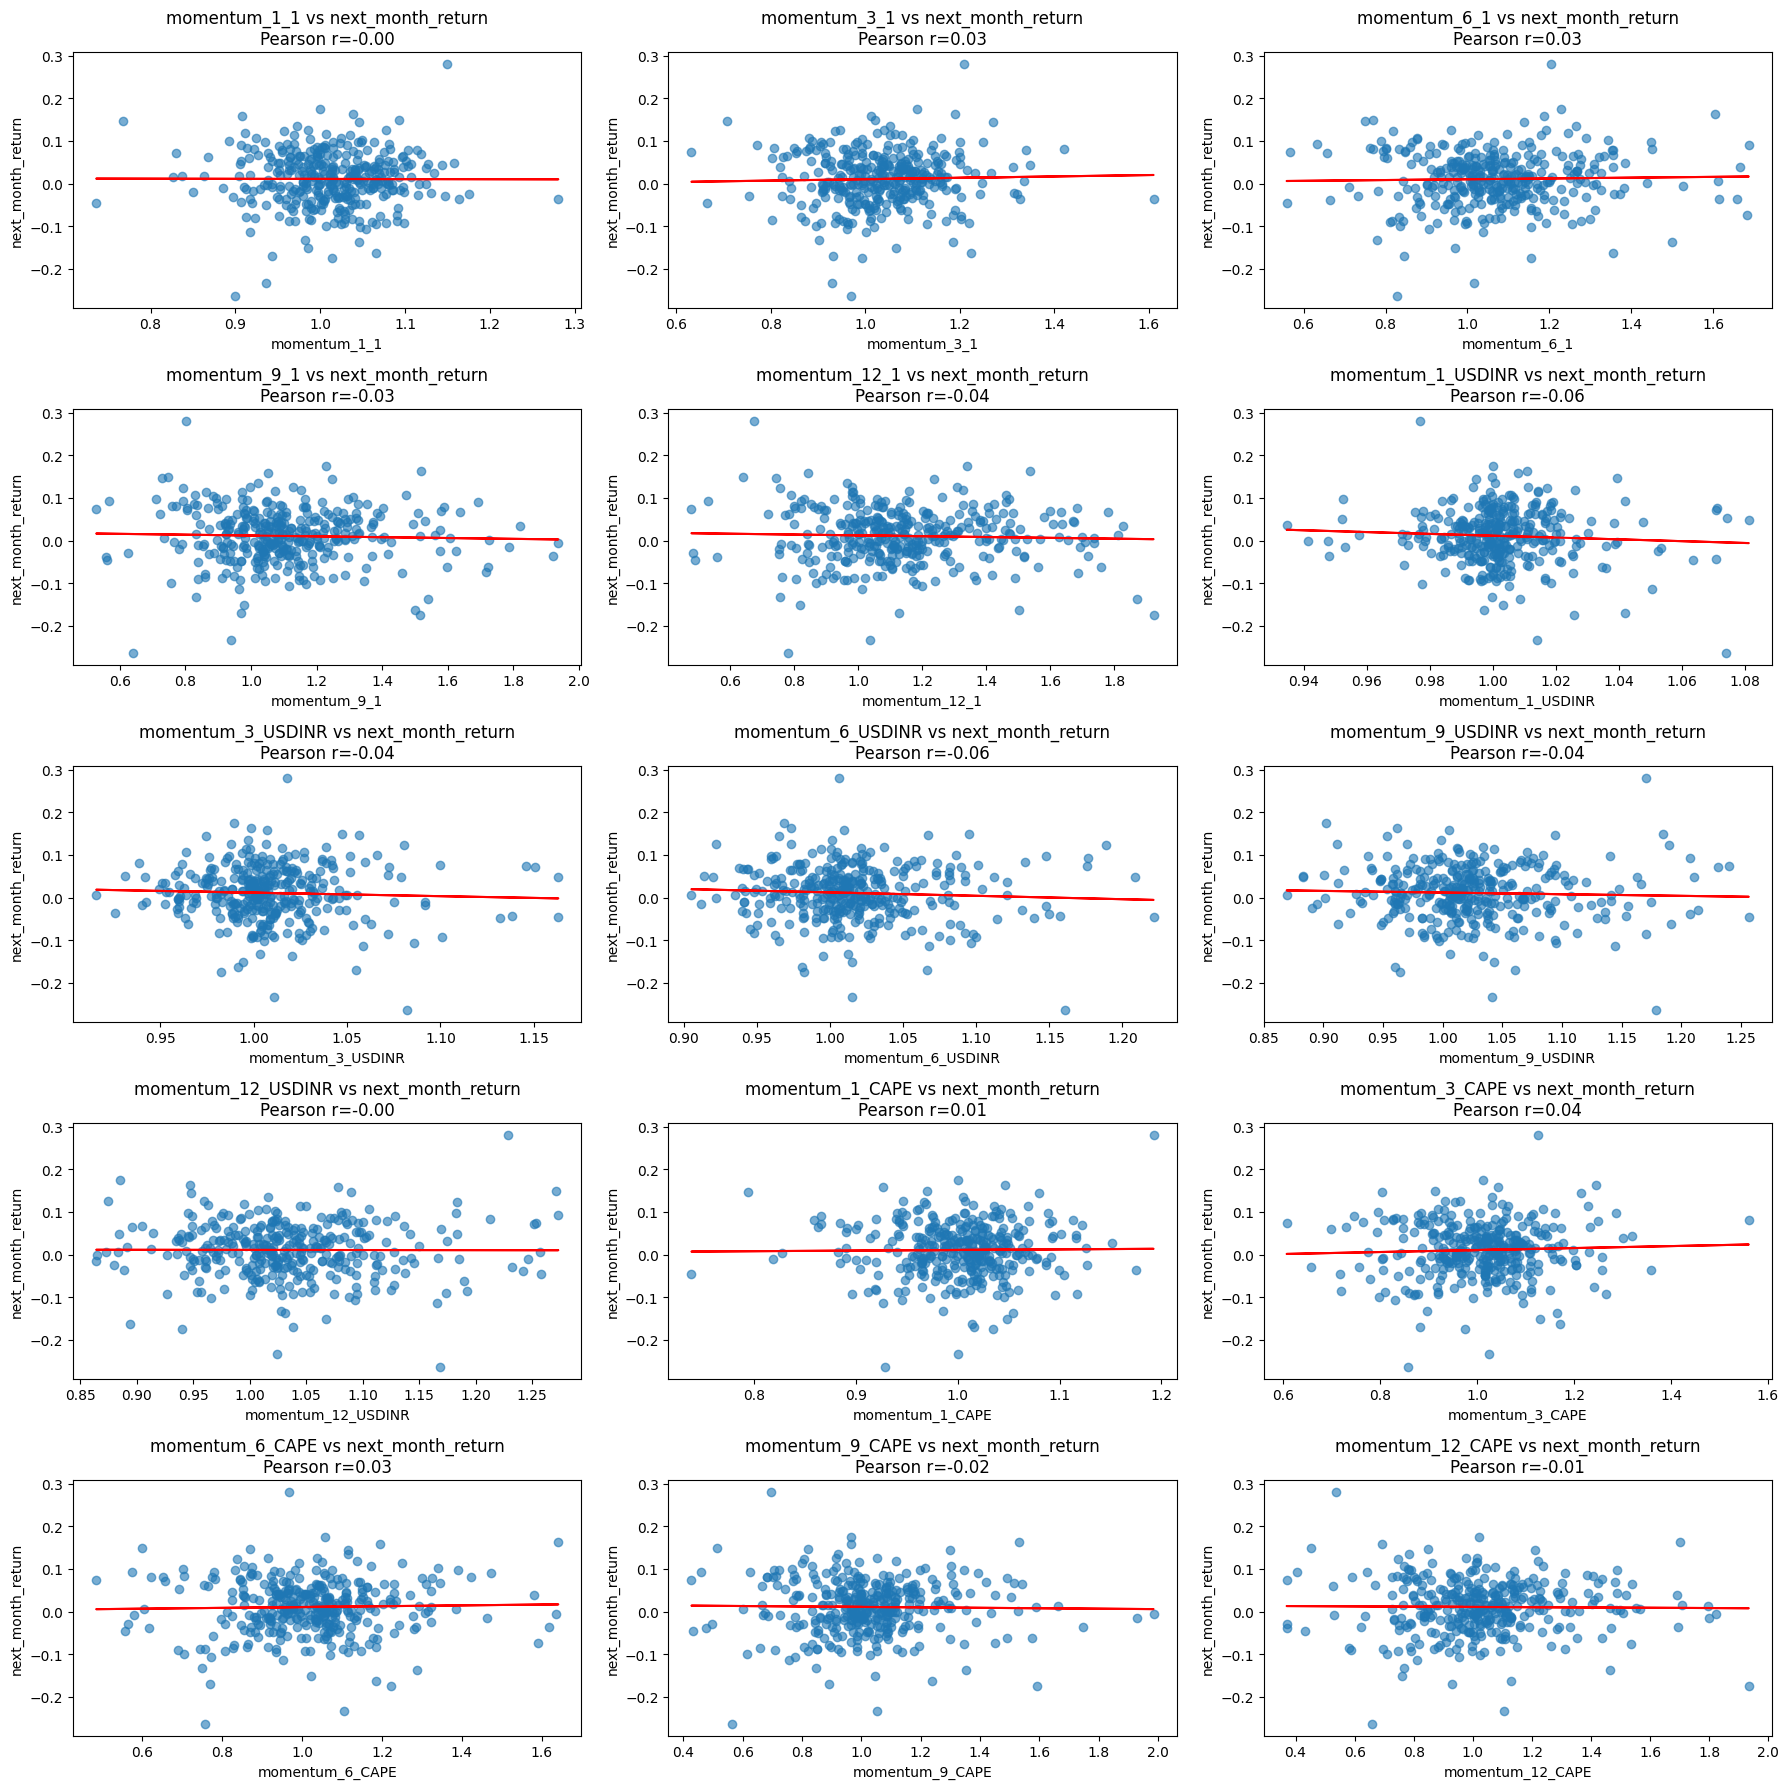

In [111]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

features = training_columns_all
target = 'next_month_return'

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 18))
axes = axes.flatten()

for i, feature in enumerate(features):
    x = training_data_final[feature]
    y = training_data_final[target]
    X_const = sm.add_constant(x)
    model = sm.OLS(y, X_const).fit()
    axes[i].scatter(x, y, alpha=0.6)
    axes[i].plot(x, model.predict(X_const), color='red')
    axes[i].set_title(f'{feature} vs {target}\nPearson r={x.corr(y):.2f}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)

# Hide any unused subplots
for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [112]:
training_data_final.tail()

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,positive_returns,next_month_return
Date,,,,,,,,,,,,,,,,,,
2025-03-31,1.063036,0.994694,0.911220,0.979540,1.053409,32.43,0.977586,0.999869,1.021237,1.026507,1.026384,1.042095,1.017252,0.945481,0.979462,0.983025,1,0.034646
2025-04-30,1.034646,1.035128,1.005323,0.975274,1.076503,33.33,0.995698,0.984178,1.013214,1.017208,1.020743,1.027752,1.102183,1.017710,0.980583,1.011533,1,0.017116
2025-05-31,1.017116,1.118691,1.025676,0.980773,1.098532,33.45,1.002237,0.975558,1.010432,1.018267,1.023149,1.003600,1.074871,1.059215,0.993466,1.027966,1,0.030963
2025-06-30,1.030963,1.084939,1.079182,0.988617,1.062741,33.93,1.001101,0.999024,0.998893,1.020240,1.025505,1.014350,1.046253,1.064304,0.989213,1.024766,0,-0.029341
2025-07-31,0.970659,1.017841,1.053596,1.023259,0.992674,32.73,1.026438,1.029867,1.013573,1.043476,1.047589,0.964633,0.981998,1.082341,0.999389,0.962930,1,-0.013788


## Training random forest model 

In [120]:
training_columns = [
       'momentum_3_1', 'momentum_6_1', 'momentum_9_1',
       'momentum_1_CAPE']

In [121]:
training_data_final

split_of_date_to_use = round(0.75*len(training_data_final))
# Features and target variable
X = training_data_final[training_columns].iloc[:split_of_date_to_use]
y = training_data_final['positive_returns'].iloc[:split_of_date_to_use]

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X, y)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.64150943 0.52830189 0.66037736 0.62264151 0.66037736]
Mean Accuracy: 0.6226
Standard Deviation: 0.0492


### Prediction on test data

In [122]:
from sklearn.metrics import accuracy_score

test_data_final = training_data_final.iloc[split_of_date_to_use:]
test_data_final['market_regime'] = clf.predict(test_data_final[training_columns])

# Compute Confusion Matrix
cm = confusion_matrix(test_data_final["positive_returns"], test_data_final["market_regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)

acc_score = accuracy_score(test_data_final["positive_returns"], test_data_final["market_regime"])
print(f"Accuracy: {acc_score*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0           10           12
Actual 1            9           57
Accuracy: 76.14%


In [123]:
test_data_final

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,positive_returns,next_month_return,market_regime
Date,,,,,,,,,,,,,,,,,,,
2018-04-30,1.061862,0.973852,1.039094,1.065718,1.154266,23.63,1.021348,1.045926,1.027027,1.036148,1.034697,1.020734,0.976850,1.054440,1.066336,1.112524,1,-0.000298,1
2018-05-31,0.999702,1.023187,1.049831,1.082502,1.115879,24.18,1.013534,1.033742,1.045610,1.054278,1.044961,1.023275,1.015113,1.049479,1.094613,1.115314,1,-0.002035,1
2018-06-30,0.997965,1.059385,1.017435,1.094569,1.125345,24.23,1.015727,1.051451,1.072536,1.048392,1.059424,1.002068,1.046652,1.042151,1.091933,1.099365,1,0.059939,1
2018-07-31,1.059939,1.057466,1.029816,1.098807,1.126961,24.05,1.001169,1.030677,1.078012,1.058533,1.067934,0.992571,1.017774,0.994212,1.073182,1.085289,1,0.028530,1
2018-08-31,1.028530,1.087960,1.113187,1.142174,1.177719,25.11,1.035891,1.053412,1.088957,1.101458,1.110590,1.044075,1.038462,1.054156,1.089844,1.136713,0,-0.064214,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,1.063036,0.994694,0.911220,0.979540,1.053409,32.43,0.977586,0.999869,1.021237,1.026507,1.026384,1.042095,1.017252,0.945481,0.979462,0.983025,1,0.034646,0
2025-04-30,1.034646,1.035128,1.005323,0.975274,1.076503,33.33,0.995698,0.984178,1.013214,1.017208,1.020743,1.027752,1.102183,1.017710,0.980583,1.011533,1,0.017116,1
2025-05-31,1.017116,1.118691,1.025676,0.980773,1.098532,33.45,1.002237,0.975558,1.010432,1.018267,1.023149,1.003600,1.074871,1.059215,0.993466,1.027966,1,0.030963,1


## PCA and Logistic Regression

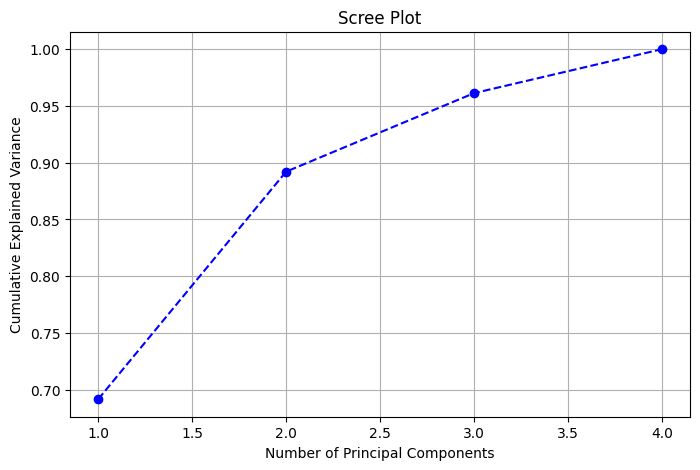

In [124]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(training_data_final[training_columns])

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Plot the explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot")
plt.grid()
plt.show()


In [125]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

y = training_data_final['positive_returns']

scores = []
for k in range(1, X.shape[1] + 1):
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_scaled)
    score = np.mean(cross_val_score(LogisticRegression(), X_pca, y, cv=5))
    scores.append(score)

optimal_k = np.argmax(scores) + 1
print(f"Optimal number of components based on CV: {optimal_k}")

Optimal number of components based on CV: 1


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification

X = training_data_final[training_columns].iloc[:split_of_date_to_use]
y = training_data_final['positive_returns'].iloc[:split_of_date_to_use]

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA (retain enough variance)
pca = PCA(n_components=4)  # Choose components based on explained variance
X_pca = pca.fit_transform(X_scaled)

# Step 4: Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.8, random_state=42)

# Step 5: Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test)

# Step 7: Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


X_scaled_full = scaler.fit_transform(X)
X_pca_full = pca.fit_transform(X_scaled_full)
model.fit(X_pca_full, y)

Accuracy: 0.68

Confusion Matrix:
 [[  5  56]
 [ 11 140]]

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.08      0.13        61
           1       0.71      0.93      0.81       151

    accuracy                           0.68       212
   macro avg       0.51      0.50      0.47       212
weighted avg       0.60      0.68      0.61       212



LogisticRegression()

In [127]:
test_data_final_lr = training_data_final.iloc[split_of_date_to_use:]
X_test_scaled = scaler.fit_transform(test_data_final_lr[training_columns])
# Step 3: Apply PCA (retain enough variance)
X_pca_test = pca.fit_transform(X_test_scaled)

test_data_final_lr['market_regime'] = model.predict(X_pca_test)

# Compute Confusion Matrix
cm_lr = confusion_matrix(test_data_final_lr["positive_returns"], test_data_final_lr["market_regime"])

# Convert to DataFrame for better visualization
cm_df_lr = pd.DataFrame(cm_lr, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df_lr)

acc_score_lr = accuracy_score(test_data_final_lr["positive_returns"], test_data_final_lr["market_regime"])
print(f"Accuracy: {acc_score_lr*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0            0           22
Actual 1            0           66
Accuracy: 75.00%


## XGBoost

In [128]:
import xgboost as xgb

# split_of_date_to_use = int(len(training_data_final)*0.8)
# Step 1: Generate Synthetic Data (Replace this with your dataset)
X = training_data_final[training_columns].iloc[:split_of_date_to_use]
y = training_data_final['positive_returns'].iloc[:split_of_date_to_use]

# Step 2: Standardize Data (Optional, but improves performance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# Step 3: Define XGBoost Model
model_xg = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=16,  # Number of trees
    learning_rate=0.1,  # Learning rate
    max_depth=3,  # Tree depth
    subsample=1,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42
)

# Step 4: Set Up K-Fold Cross-Validation
k = 5  # Number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Step 5: Perform Cross-Validation
cv_scores = cross_val_score(model_xg, X_scaled, y, cv=kf, scoring='accuracy')

# Step 6: Print Results
print(f"Cross-Validation Accuracies: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation: {np.std(cv_scores):.2f}")

model_xg.fit(X, y)


Cross-Validation Accuracies: [0.69811321 0.71698113 0.71698113 0.71698113 0.71698113]
Mean Accuracy: 0.71
Standard Deviation: 0.01


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=16,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [129]:
test_data_xg = training_data_final.iloc[split_of_date_to_use:]
X_scaled_test_xg = scaler.fit_transform(test_data_xg[training_columns])
test_data_xg['market_regime'] = model_xg.predict(X_scaled_test_xg)
# Compute Confusion Matrix
cm_xg = confusion_matrix(test_data_xg["positive_returns"], test_data_xg["market_regime"])

# Convert to DataFrame for better visualization
cm_df_xg = pd.DataFrame(cm_xg, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df_xg)

acc_score_xg = accuracy_score(test_data_xg["positive_returns"], test_data_xg["market_regime"])
print(f"Accuracy: {acc_score_xg*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0            0           22
Actual 1            0           66
Accuracy: 75.00%


In [130]:
test_data_xg

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,positive_returns,next_month_return,market_regime
Date,,,,,,,,,,,,,,,,,,,
2018-04-30,1.061862,0.973852,1.039094,1.065718,1.154266,23.63,1.021348,1.045926,1.027027,1.036148,1.034697,1.020734,0.976850,1.054440,1.066336,1.112524,1,-0.000298,1
2018-05-31,0.999702,1.023187,1.049831,1.082502,1.115879,24.18,1.013534,1.033742,1.045610,1.054278,1.044961,1.023275,1.015113,1.049479,1.094613,1.115314,1,-0.002035,1
2018-06-30,0.997965,1.059385,1.017435,1.094569,1.125345,24.23,1.015727,1.051451,1.072536,1.048392,1.059424,1.002068,1.046652,1.042151,1.091933,1.099365,1,0.059939,1
2018-07-31,1.059939,1.057466,1.029816,1.098807,1.126961,24.05,1.001169,1.030677,1.078012,1.058533,1.067934,0.992571,1.017774,0.994212,1.073182,1.085289,1,0.028530,1
2018-08-31,1.028530,1.087960,1.113187,1.142174,1.177719,25.11,1.035891,1.053412,1.088957,1.101458,1.110590,1.044075,1.038462,1.054156,1.089844,1.136713,0,-0.064214,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,1.063036,0.994694,0.911220,0.979540,1.053409,32.43,0.977586,0.999869,1.021237,1.026507,1.026384,1.042095,1.017252,0.945481,0.979462,0.983025,1,0.034646,1
2025-04-30,1.034646,1.035128,1.005323,0.975274,1.076503,33.33,0.995698,0.984178,1.013214,1.017208,1.020743,1.027752,1.102183,1.017710,0.980583,1.011533,1,0.017116,1
2025-05-31,1.017116,1.118691,1.025676,0.980773,1.098532,33.45,1.002237,0.975558,1.010432,1.018267,1.023149,1.003600,1.074871,1.059215,0.993466,1.027966,1,0.030963,1


### View Portfolio

In [ ]:
sheet_id = "10cMWuCXMb5-7tgaHWS5Ef-D0rNNhWSvgElVnY8f4t2c"
sheet_name = "Holdings"  # or your specific sheet name
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
portfolio_data = pd.read_csv(url)

portfolio_data.head()

,Portfolio Date,Holding,Weight,Buy Price,Shares,Current Price,Portfolio Value
0,01-03-2025,GOLDBEES,0.33,72.26,0.456684,72.26,100
1,01-03-2025,HNGSNGBEES,0.33,445.81,0.074023,445.81,100
2,01-03-2025,LTGILTBEES,0.34,27.67,1.228768,27.67,100


In [ ]:
today = datetime.today()
# Convert to the first day of the current month
month_start = pd.to_datetime(today).replace(day=1).strftime("%d-%m-%Y")
current_portfolio = portfolio_data[portfolio_data['Portfolio Date'] == month_start]
current_portfolio

,Portfolio Date,Holding,Weight,Buy Price,Shares,Current Price,Portfolio Value
0,01-03-2025,GOLDBEES,0.33,72.26,0.456684,72.26,100
1,01-03-2025,HNGSNGBEES,0.33,445.81,0.074023,445.81,100
2,01-03-2025,LTGILTBEES,0.34,27.67,1.228768,27.67,100


## Making next month prediciton using the final Model

In [ ]:
X = training_data_final[training_columns][:-1]
y = training_data_final['positive_returns'][:-1]

print(X.tail())

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X, y)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

            momentum_3_1  momentum_6_1  momentum_3_USDINR  momentum_6_USDINR  \
Date                                                                           
2024-11-30      0.956221      1.071032           1.006872           1.013811   
2024-12-31      0.916080      0.984765           1.024729           1.027989   
2025-01-31      0.971207      0.942177           1.030419           1.034727   
2025-02-28      0.916854      0.876715           1.033803           1.040907   
2025-03-31      0.994694      0.911220           0.997111           1.021769   

            momentum_1_CAPE  momentum_3_CAPE  
Date                                          
2024-11-30         0.964275         0.937927  
2024-12-31         1.009500         0.929446  
2025-01-31         0.948557         0.923359  
2025-02-28         1.029101         0.985434  
2025-03-31         1.042095         1.017252  
Cross-Validation Scores: [0.67142857 0.8        0.67142857 0.74285714 0.8115942 ]
Mean Accuracy: 0.7395
Standa

In [ ]:
from sklearn.metrics import accuracy_score

test_data_final = training_data_final.iloc[-1:]
test_data_final['market_regime'] = clf.predict(test_data_final[training_columns])
test_data_final['market_regime']

Date
2025-04-30    1
Name: market_regime, dtype: int64